In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

master = pd.read_csv('final_data_set.csv', sep = ';', encoding = 'utf-8')
# Netwulf kan ikke finde ud af Nan
master = master.dropna(subset=["laureate_name", "affiliation"])

In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
G_bi = nx.Graph()
G_bi.add_nodes_from(master["laureate_name"], bipartite = 0)
G_bi.add_nodes_from(master["affiliation"], bipartite = 1)
edge_list = list(master[["laureate_name", "affiliation"]].to_records(index=False))
G_bi.add_edges_from(edge_list)

node_attr = {n:d["bipartite"] for n, d in G_bi.nodes(data=True)}
nx.set_node_attributes(G_bi, node_attr, name = 'group')

# Bipartite Laureate to Affiliation

In [24]:
import netwulf as nw
plt.style.use('seaborn-white')

network, config = nw.visualize(G_bi, plot_in_cell_below=False)

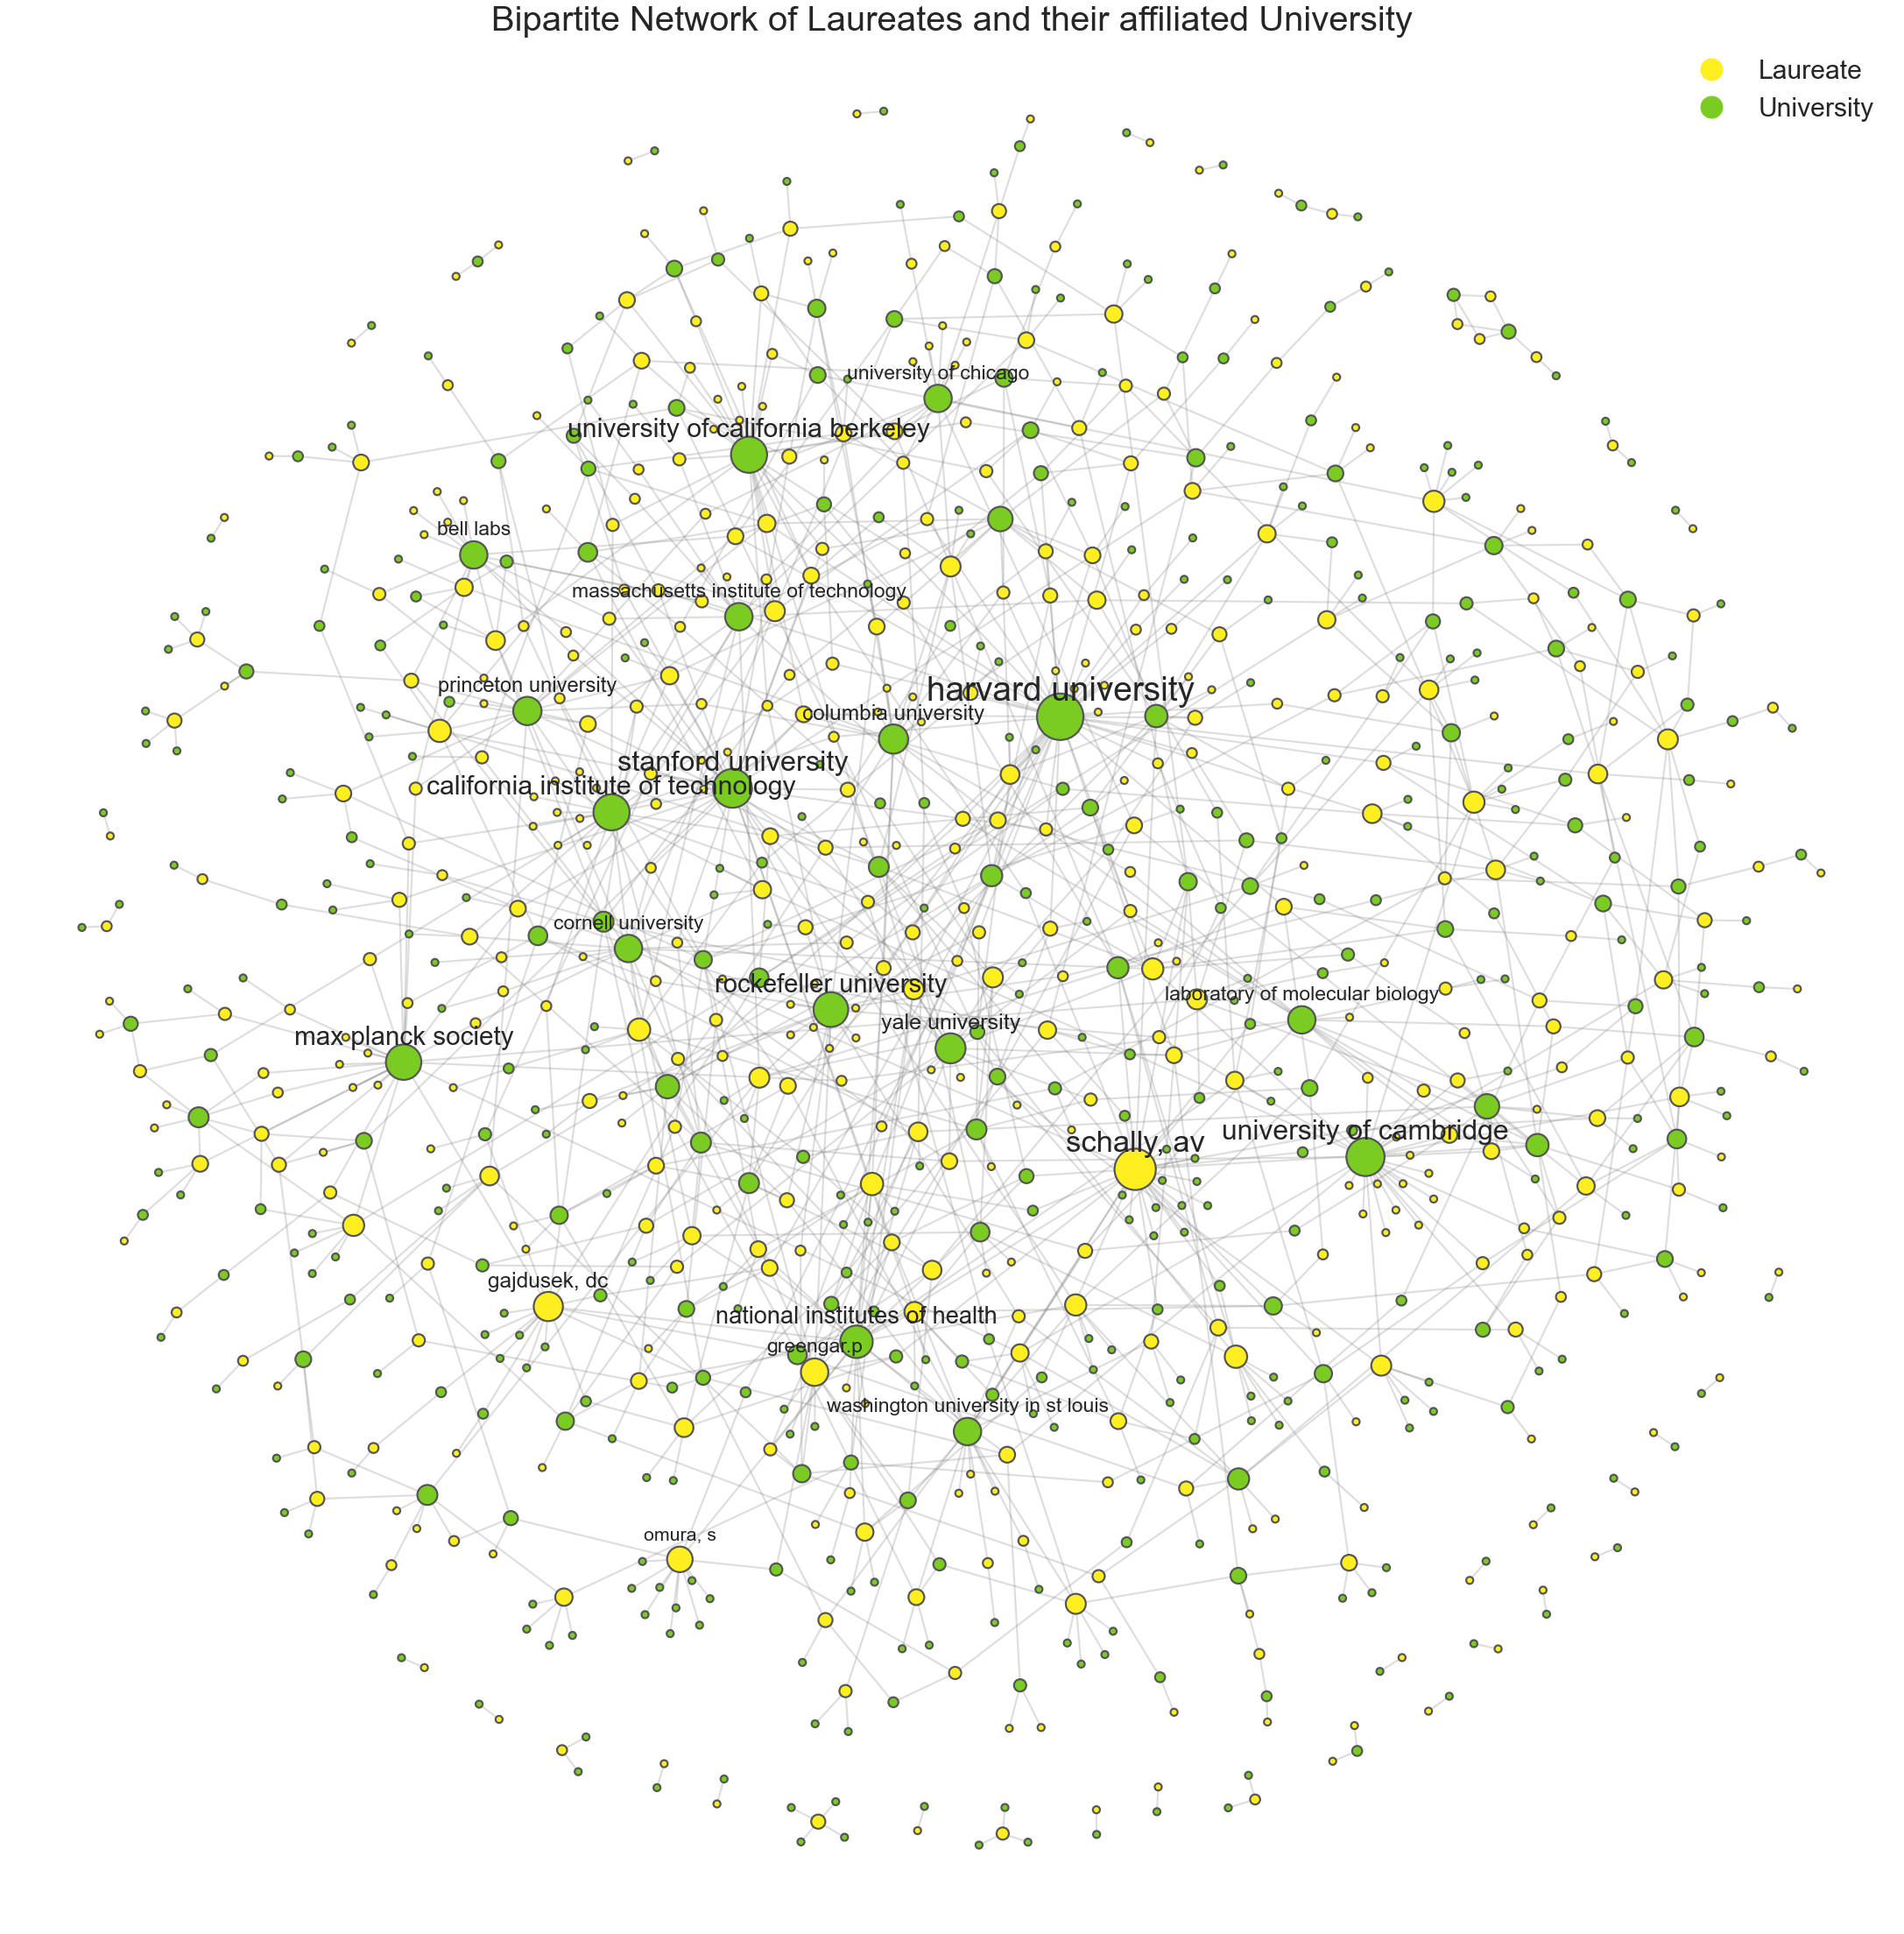

In [92]:
# Drawing the network
fig, ax = nw.draw_netwulf(network)

# Dict to assign labels to the plot 
laureate_dict = dict.fromkeys(master["laureate_name"], "Laureate")
university_dict = dict.fromkeys(master["affiliation"], "University")
laureate_dict.update(university_dict)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>6: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*3.5)
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {laureate_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 25)

plt.legend(fontsize = 30)
plt.title('Bipartite Network of Laureates and their affiliated University', size = 40)

# Saving as pdf
plt.savefig('Plots/bipartite_laureate_uni.', dpi=None, facecolor='w', edgecolor='w')

In [3]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(G=None, top_n = 50, hue_name = None ,hue_dict = None):
    
    _df = pd.DataFrame(sorted(dict(G.degree()).items(), key = lambda x: x[1], reverse = True)[:top_n],
                       columns = ['Name','count'])

    _df[hue_name] = _df.Name.apply(lambda x: hue_dict[x])
    
    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(data = _df, x='Name', y='count', hue = hue_name, palette = "deep",ax=ax)
    ax.set_ylabel('Degree', size = 15)
    plt.xticks(rotation=90, size = 12)
    ax.set_title(f'Distribution of degree for top {top_n} node', size = 15)
    return fig

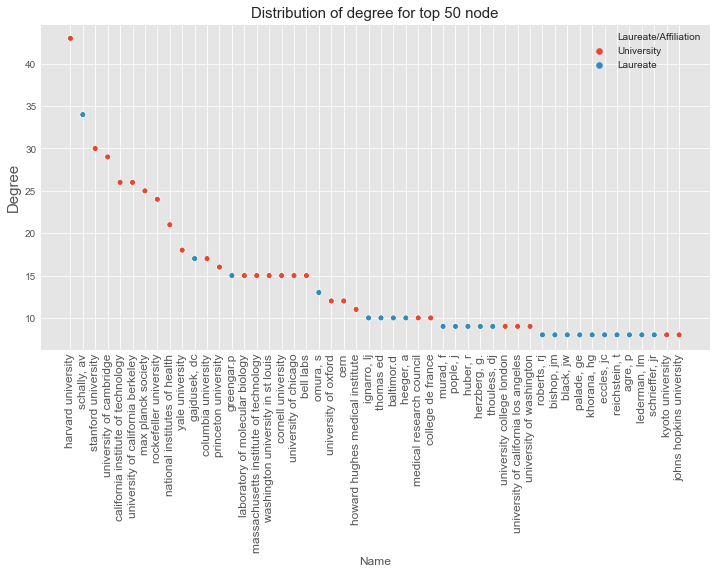

In [90]:
f = plot_top_nodes(G=G_bi,
                   hue_name = 'Laureate/Affiliation',
                   hue_dict = laureate_dict)

In [148]:
# Saving as pdf
f.tight_layout()
f.savefig('Plots/top_connected.', dpi=None, facecolor='w', edgecolor='w')

## Degree Distribution

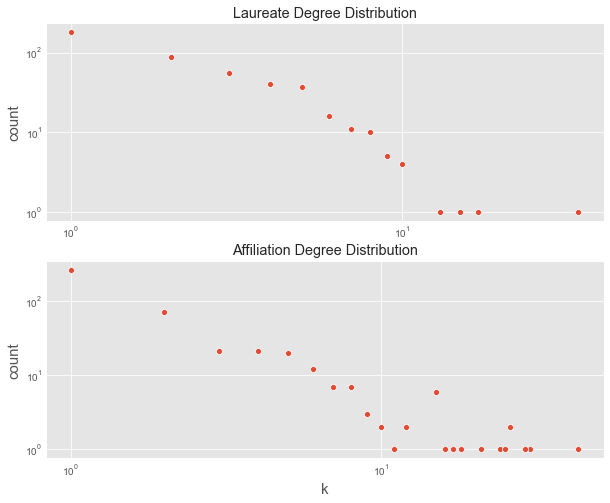

In [84]:
plt.style.use('ggplot')
lau_deg_dist = pd.Series([G_bi.degree()[n] for n,attr in G_bi.nodes(data=True) if\
                          attr['bipartite'] == 0]).value_counts()
uni_deg_dist = pd.Series([G_bi.degree()[n] for n,attr in G_bi.nodes(data=True) if\
                          attr['bipartite'] == 1]).value_counts()

fig, ax = plt.subplots(2,1, figsize=(10,8))

sns.scatterplot(x=lau_deg_dist.index, y=lau_deg_dist, ax = ax[0])
sns.scatterplot(x=uni_deg_dist.index, y=uni_deg_dist, ax = ax[1])

ax[0].set_title('Laureate Degree Distribution')
ax[0].set_ylabel('count', size = 15)
ax[1].set_title('Affiliation Degree Distribution')
ax[1].set_ylabel('count', size = 15)
ax[1].set_xlabel('k', size = 15)
# logscale the axes
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

## Projection of Bipartite Network

In [12]:
## Split into projections 
top_nodes = {n for n, d in G_bi.nodes(data=True) if d["bipartite"] == 0} # Laureates 
bottom_nodes = set(G_bi) - top_nodes

## Projections 
G_top_pro = bipartite.projection.projected_graph(G_bi, top_nodes) # laureates 
G_bottom_pro = bipartite.projection.projected_graph(G_bi, bottom_nodes) # affiliation 

### Laureate projections!! 

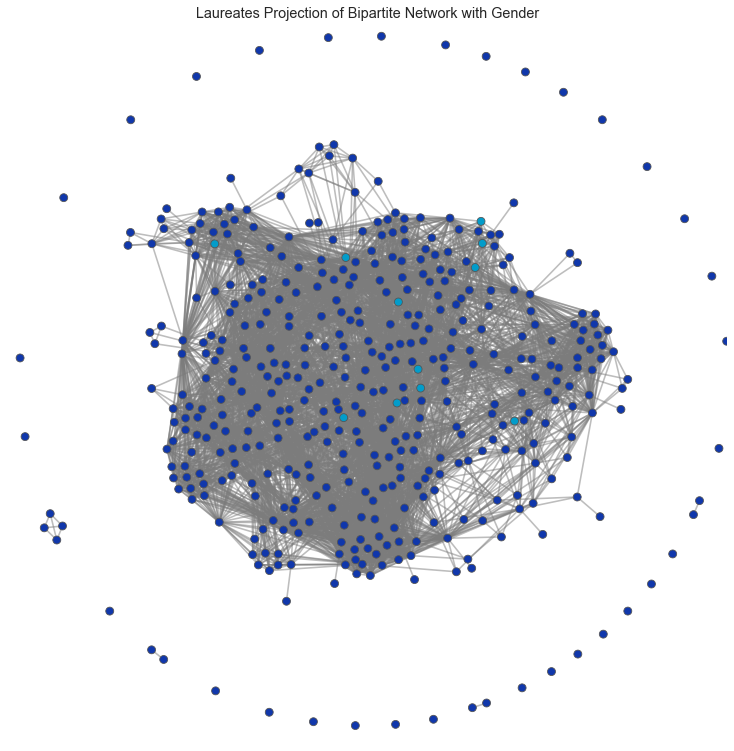

In [95]:
gender_dict = master.set_index('laureate_name')['gender_mf'].to_dict()
_gender = {n:gender_dict[n] for n in G_top_pro.nodes()}
# Assign communty labels
nx.set_node_attributes(G_top_pro, _gender, 'group')
#Use netwulf to visualize
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

fig, ax = nw.draw_netwulf(network, figsize = 10)
plt.title('Laureates Projection of Bipartite Network with Gender')
plt.show()

## Laurate projection with Nationality 

In [124]:
master.nationality = master.nationality.apply(lambda x: x.split(',')[0])
name_nat_dict = {name:nat for name, nat in zip(master.laureate_name, master.nationality)}
# Assign communty labels
nx.set_node_attributes(G_top_pro, name_nat_dict, 'group')
#Use netwulf to visualize
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

<ipython-input-163-16bfaa25d618>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


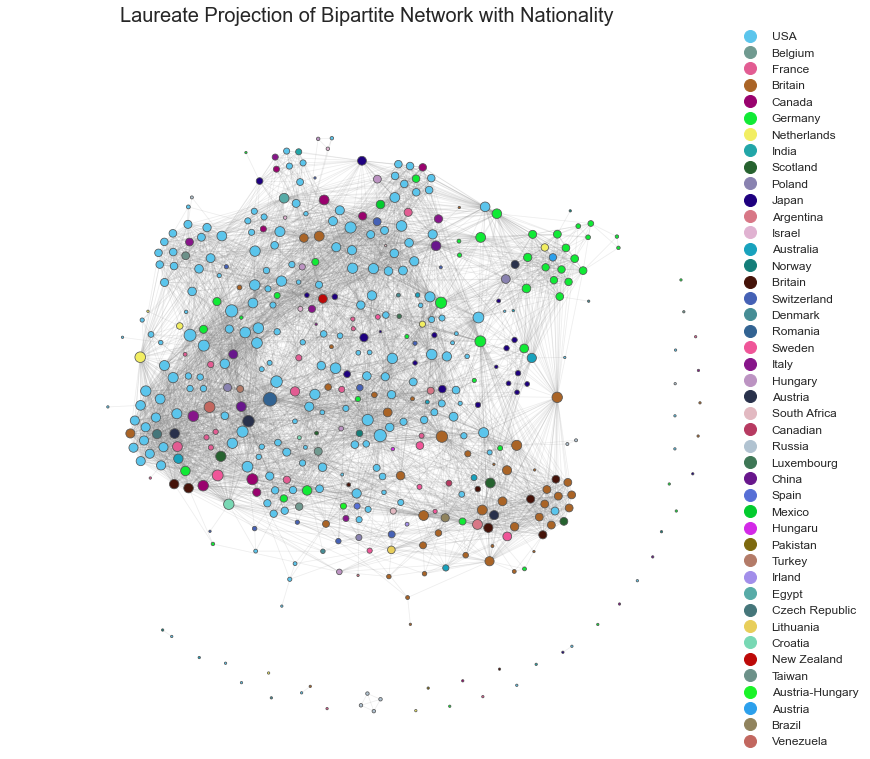

In [163]:
fig, ax = nw.draw_netwulf(network, figsize = 10)
ax.set_title('Laureate Projection of Bipartite Network with Nationality', size = 20)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>10: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*2)
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {name_nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
# Place legend
plt.legend(bbox_to_anchor = (1,1.01), fontsize = 12)
# Saving as pdf
fig.tight_layout()
plt.savefig('Plots/laureate_projection_nationality.png', dpi=200, bbox_inches='tight')

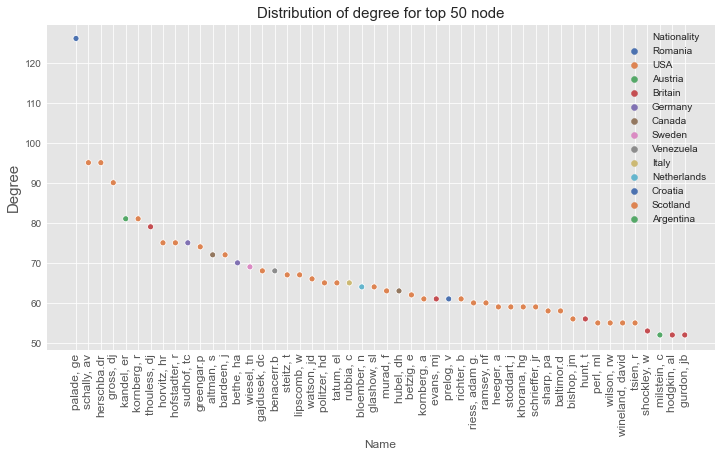

In [184]:
f = plot_top_nodes(G=G_top_pro,
                   hue_name = 'Nationality',
                   hue_dict = name_nat_dict)

# Saving as pdf
f.savefig('Plots/top_connected_laureate_bipart.png', dpi=None, facecolor='w', edgecolor='w',
         bbox_inches="tight")

### University Projection

In [180]:
import netwulf as nw
cont_dict = master.set_index('affiliation')['continent'].to_dict()
_continent = {n:cont_dict[n] if pd.isna(cont_dict[n])==False else 'NAm' for n in G_bottom_pro.nodes()}
# Assign communty labels
nx.set_node_attributes(G_bottom_pro, _continent, 'group')
#Use netwulf to visualize
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

<ipython-input-181-a523a2363ff3>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


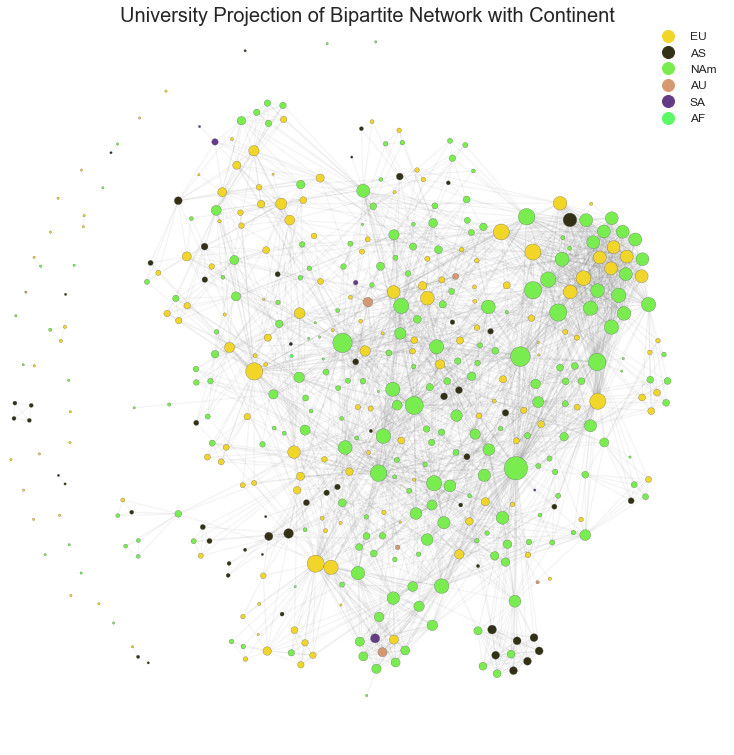

In [181]:
fig, ax = nw.draw_netwulf(network, figsize = 10)
ax.set_title('University Projection of Bipartite Network with Continent', size = 20)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>105: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*2)
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {_continent[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
# Place legend
plt.legend(bbox_to_anchor = (1,1.01), fontsize = 12)
# Saving as pdf
fig.tight_layout()
plt.savefig('Plots/university_projection_continent.png', dpi=200, bbox_inches='tight')

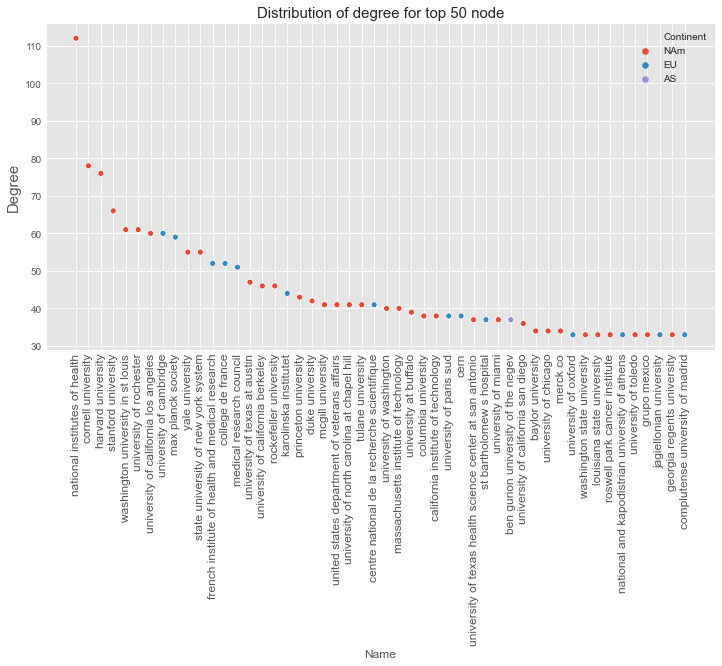

In [182]:
f = plot_top_nodes(G=G_bottom_pro,
                   hue_name = 'Continent',
                   hue_dict = _continent)

# Saving as pdf
f.savefig('Plots/top_connected_university_bipart.png', dpi=None, facecolor='w', edgecolor='w',
         bbox_inches="tight")

In [13]:
import netwulf as nw
nat_dict = {name:(nat if pd.isna(nat)==False else 'USA') \
            for name, nat in zip(master.affiliation, master.uni_nationality)}
# Assign communty labels
nx.set_node_attributes(G_bottom_pro, nat_dict, 'group')
#Use netwulf to visualize
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

<ipython-input-14-48aad004e8d1>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


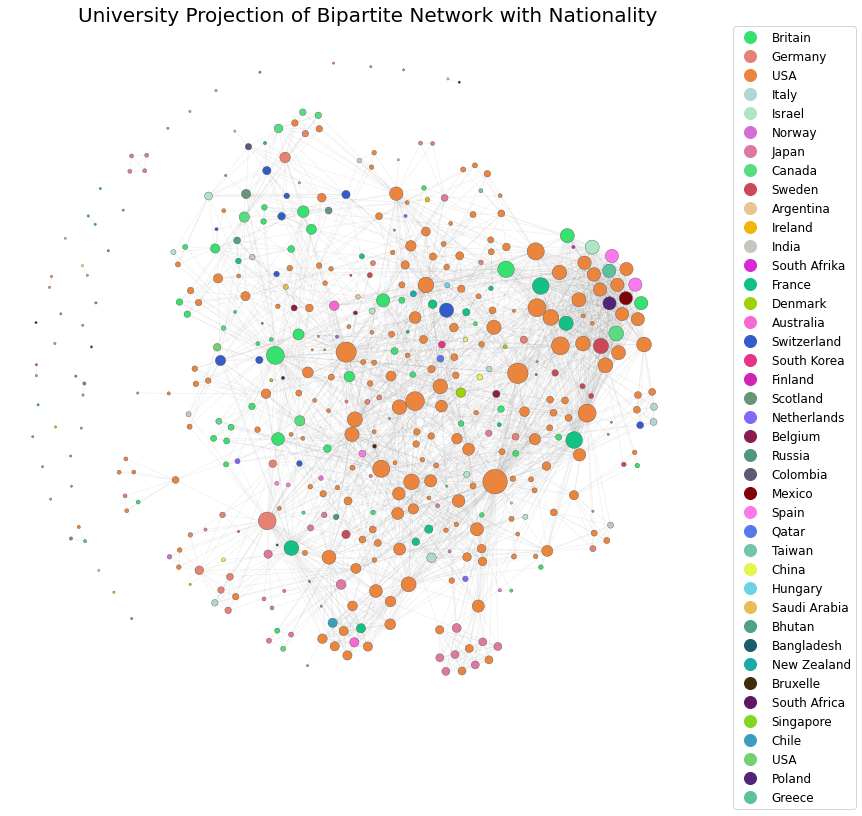

In [14]:
fig, ax = nw.draw_netwulf(network, figsize = 10)
ax.set_title('University Projection of Bipartite Network with Nationality', size = 20)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>105: # add label if it is of a particular size 
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*2)
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {nat_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)
# Place legend
plt.legend(bbox_to_anchor = (1,1.01), fontsize = 12)
# Saving as pdf
fig.tight_layout()
plt.savefig('Plots/university_projection_nationality.png', dpi=200, bbox_inches='tight')

# Community detection 

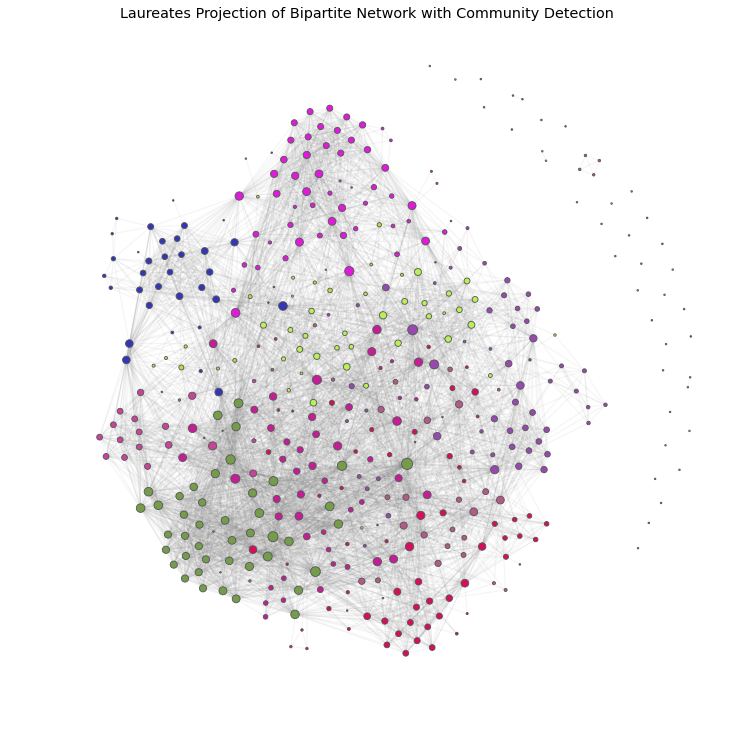

In [57]:
import community
import netwulf as nw
#Detect communities with louvrain modularity
partitions = community.best_partition(G_top_pro)
# Assign communty labels
nx.set_node_attributes(G_top_pro, partitions, 'group')
#Use netwulf to visualize
network, config = nw.visualize(G_top_pro, plot_in_cell_below=False)

fig, ax = nw.draw_netwulf(network, figsize = 10)
plt.title('Laureates Projection of Bipartite Network with Community Detection')
plt.show()

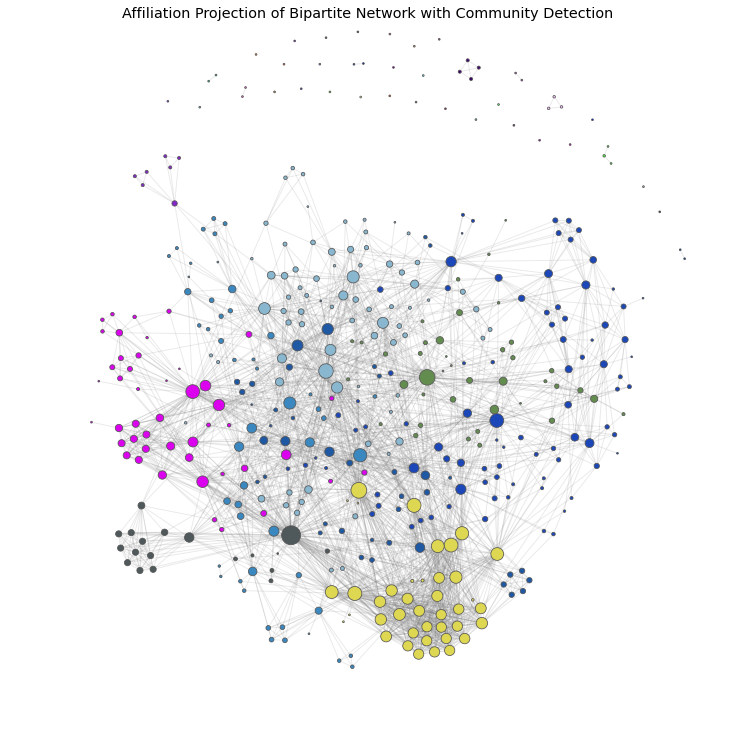

In [60]:
#Detect communities with louvrain modularity
partitions = community.best_partition(G_bottom_pro)
# Assign communty labels
nx.set_node_attributes(G_bottom_pro, partitions, 'group')
#Use netwulf to visualize
network, config = nw.visualize(G_bottom_pro, plot_in_cell_below=False)

fig, ax = nw.draw_netwulf(network, figsize = 10)
plt.title('Affiliation Projection of Bipartite Network with Community Detection')
plt.show()